# Zwarte Piet tweets dataset
Read and index with ElasticSearch the local json dataset. Various trimming and cleaning is performed to minimize the index size. After indexing, we perform some simple queries using the elasticsearch-dsl library. The script assumes that the local json datasets are stored in a folder named "Data".

In [1]:
import re
import numpy as np
import pandas as pd
from datetime import datetime
from elasticsearch import Elasticsearch
import json
import os

es = Elasticsearch()


First we define which fields from the original dataset json files would be included in the ES database. The original set contains more than 1000 fields per item/tweet; most of which are not interesting to us. Each tweet comes with a user field as well, containing the info of the user the posted the tweet. The user field should also be truncated. We later enrich the user with the "sentiment" and "isNews" fields. We enrich the tweet documents with "activist" and "zp" (whether they mention zwarte piet).

In [13]:
include_keys = ["created_at","id","text","user","retweet_count",
                "favorite_count","lang","activist","zp"]
include_user_keys  = ["id","location","description","followers_count",
                      "friends_count","listed_count","favourites_count",
                      "verified","lang","statuses_count","sentiment","isNews"]

We now proceed with indexing the "filtered" dataset. First, we read the local json files.  This might take time to complete especially if all datasets are used. As such, for demo purposes we set NUM (num of json files) set to 1 and TWEETSPERDATA is set to 100. For the final version, all the data should be used.

In [133]:
""" Filtered """
import time

TWEETSPERDATA = 200 # Very large numbers to include everything or float("Inf")
NUM = 2000

def readJsonFolder(folder):
    """ 
        Function to read jsons from a folder. Each json 
        contains multiple items. All items are concatenated
        into a single output json file.
    """
    print('Reading folder %s'%folder)
    LOC = folder
    data = []
    files = os.listdir(LOC)
    for file in files[:min(NUM,len(files))]:
        print(file)
        with open(LOC+"/"+file) as json_file: 
            try:
                tweets = json.load(json_file)
                data += tweets[:min(TWEETSPERDATA,len(tweets))]
            except:
                print("%s skipped"%file)
    return data
start = time.time()
act_zp = readJsonFolder('Data/with_status_count/activist/zp')
act_nzp = readJsonFolder('Data/with_status_count/activist/non_zp')
ver_zp = readJsonFolder('Data/with_status_count/verified/zp')
ver_nzp = readJsonFolder('Data/with_status_count/verified/non_zp')
end = time.time()
print("Done!")
print("Time elapsed in seconds: %d"%(end-start))

Reading folder Data/with_status_count/activist/zp
zp_filter_wstatusactivist_piet90.json
zp_filter_wstatusactivist_piet80.json
zp_filter_wstatusactivist_piet40.json
zp_filter_wstatusactivist_piet110.json
zp_filter_wstatusactivist_piet60.json
zp_filter_wstatusactivist_piet20.json
zp_filter_wstatusactivist_piet70.json
zp_filter_wstatusactivist_piet50.json
zp_filter_wstatusactivist_piet100.json
zp_filter_wstatusactivist_piet10.json
zp_filter_wstatusactivist_piet30.json
Reading folder Data/with_status_count/activist/non_zp
zp_filter_wstatusactivist_no_piet30.json
zp_filter_wstatusactivist_no_piet10.json
zp_filter_wstatusactivist_no_piet110.json
zp_filter_wstatusactivist_no_piet50.json
zp_filter_wstatusactivist_no_piet70.json
zp_filter_wstatusactivist_no_piet20.json
zp_filter_wstatusactivist_no_piet60.json
zp_filter_wstatusactivist_no_piet40.json
zp_filter_wstatusactivist_no_piet100.json
zp_filter_wstatusactivist_no_piet80.json
zp_filter_wstatusactivist_no_piet90.json
Reading folder Data/wit

The tweets need to be enriched with expert sentiment annotations. We read the annotations from the csv files.

In [4]:
import pandas as pd

annotations_act = pd.read_csv("Data/zpiet-activist-sentiment.csv", sep = ";",  header='infer')
annotations_act = annotations_act.replace(np.nan, False, regex=True) # replace NaN values
annotations_act.head()

annotations_ver = pd.read_csv("Data/zpiet-sentiment-verified.csv", sep = ";",  header='infer')
annotations_ver = annotations_ver.replace(np.nan, False, regex=True) # replace NaN values
annotations_ver = annotations_ver.replace("Y", True, regex=True) # replace NaN values
annotations_ver.head()


,All verified accounts,Catarina,Thirza,Combined,News
0,SaskiaBelleman,Neutral,neutral,Neutral,False
1,umarebru,Pro,irrelevant,Pro,False
2,OmropFryslan,Neutral,irrelevant,Neutral,True
3,AlexanderNL,Con,irrelevant,Con,False
4,True,Con,con,Con,False


The indexing part in ES is tricky. Throwing everything in ES without taking care of certain fields' particular properties will not allow us to answer certain research questions (e.g. wordclouds). So here's what we do:
- The **"text"** field is the most important. When queried, we want it to be tokenized and treated as a collection of words (instead of the typical __keyword__ type). We also want to remove any Dutch stopwords. To achieve these, we define our own **analyzer** when creating the index. And we assign the **text** to be of text type. Its "fielddata" is set to true so that it's indexable and aggregable.
- We incorporate the folder names e.g. activist, non_zp as additional fields in the json files. If a json file comes from the activist folder then its activist field is set to true. If it comes from the verified folder, the its activist field is set to false.

In [134]:
import time

# Deletion of the index if it already exists
es.indices.delete(index="zpiet-with_status_count-tweets-index", ignore=[400, 404])

# Create index with settings; for more check https://github.com/elastic/elasticsearch-py/blob/master/example/load.py
index_body = {
  "settings": {
    "analysis": {
      "analyzer": {
        "my_dutch_analyzer": {
          "type": "standard",         
          "stopwords": "_dutch_"
        }
      }
    },
      "index.mapping.total_fields.limit":2000
  },
 "mappings":{
    "tweet":{
        "properties": {
          "text": {"type": "text","analyzer": "my_dutch_analyzer","fielddata":"true"} # fielddata is needed for term search, wordclouds
         }  
    }
}
}

print("Indexing...")
start = time.time()
es.indices.create(index="zpiet-with_status_count-tweets-index",body=index_body)
i=0
for dataset,act,zp in [(act_zp,True,True), (act_nzp,True,False), (ver_zp,False,True),(ver_nzp, False,False)]:
    print("Activist: %d, ZP: %d, size: %d"%(act,zp,len(dataset)))
    for doc in dataset:
        doc.update({"activist":act})
        doc.update({"zp":zp})
        
        # Delete unwanted keys
        to_delete = []
        for key in doc.keys():
            if key not in include_keys: to_delete.append(key)
        for key in to_delete: doc.pop(key, None)
        
        # Enrich with sentiment annotations 
        name = doc["user"]["screen_name"]
        combined_sentiment = "unknown"
        sent = annotations_act.loc[annotations_act['random sample of non-verified accounts'] == name]["Combined"].values
        if len(sent)>0: combined_sentiment = sent[0]
        sent = annotations_ver.loc[annotations_ver['All verified accounts'] == name]["Combined"].values
        if len(sent)>0: combined_sentiment = sent[0]
        doc["user"].update({"sentiment":combined_sentiment})
        
        # Enrich with News annotation
        name = doc["user"]["screen_name"]
        isNews = False
        isn = annotations_ver.loc[annotations_ver['All verified accounts'] == name]["News"].values
        if len(isn)>0: isNews = isn[0]
        doc["user"].update({"isNews":bool(int(isNews))})
            
        # Delete unwanted keys in user key
        to_delete = []
        for key in doc["user"].keys():
            if key not in include_user_keys: to_delete.append(key)
        for key in to_delete: doc["user"].pop(key, None)
        
        # Index
        try:
            res = es.index(index="zpiet-with_status_count-tweets-index", doc_type='tweet', id=i, body=doc)
        except:
            print("Document not indexed probably due to sentiment value: ",combined_sentiment, "or isNews:",isNews)
        i+=1
print("Done!")
end = time.time()
print("Time elapsed in seconds: %d"%(end-start))

Indexing...
Activist: 1, ZP: 1, size: 1766
Activist: 1, ZP: 0, size: 2000
Activist: 0, ZP: 1, size: 1248
Activist: 0, ZP: 0, size: 2000
Done!
Time elapsed in seconds: 99


# Analysis for questions 1, 2 and 4
Verified accounts are those with user.verified=true. "Engagement" relates to the tweet and not to the user. As such, it corresponds to either "retweet_count" or "favorite_count". 

In [135]:
from elasticsearch_dsl import Search
from elasticsearch_dsl.query import MultiMatch, Match
from elasticsearch_dsl import Q

def exportJson(j, outfile):
    with open(outfile, "w") as data_file:
        json.dump(j, data_file, indent=2)

q1 =  Q("match", user__verified="false")
q2 =  Q("match", user__verified="true") 

# Structure to hold analysis
data = {"retweet_count":[],"favorite_count":[],"isVerified":[],"zp":[]}

# Quering
for q, isVerified in [(q1,False), (q2,True)]:
    s = Search().using(es).query(q)   
    response = s.execute()
    exportJson(response.to_dict(),"res.json")
    for hit in s.scan(): # Scan allows for 
            data["retweet_count"].append(hit.retweet_count)
            data["favorite_count"].append(hit.favorite_count)
            data["isVerified"].append(isVerified)
            data["zp"].append(hit.zp)

df = pd.DataFrame(data)
df.head()
    

,favorite_count,isVerified,retweet_count,zp
0,0,False,37,True
1,0,False,4,True
2,0,False,6,True
3,0,False,4,True
4,0,False,0,True


In [136]:
""" Summary statistics """
for g, group in df.groupby(["isVerified"]):
    print("Is verified:",g)
    print(group.describe())    

Is verified: False
       favorite_count  retweet_count
count     3766.000000    3766.000000
mean         0.747212     185.955390
std          7.440233    1465.306537
min          0.000000       0.000000
25%          0.000000       0.000000
50%          0.000000       6.000000
75%          0.000000      74.750000
max        302.000000   50935.000000
Is verified: True
       favorite_count  retweet_count
count     3248.000000    3248.000000
mean        19.145012     342.242303
std        101.742128    9353.737871
min          0.000000       0.000000
25%          0.000000       0.000000
50%          1.000000       2.000000
75%          5.000000       9.000000
max       2701.000000  497481.000000


In [100]:
""" Histograms of retweet_count and favorite_count"""
df_ = df[df.retweet_count < 50]
#hist = df_.hist(column="retweet_count",by="isVerified")

df_ = df[df.favorite_count < 20]
#hist = df_.hist(column="favorite_count",by="isVerified")

## Question 1: Verified gets more engagement

<IPython.core.display.Javascript object>


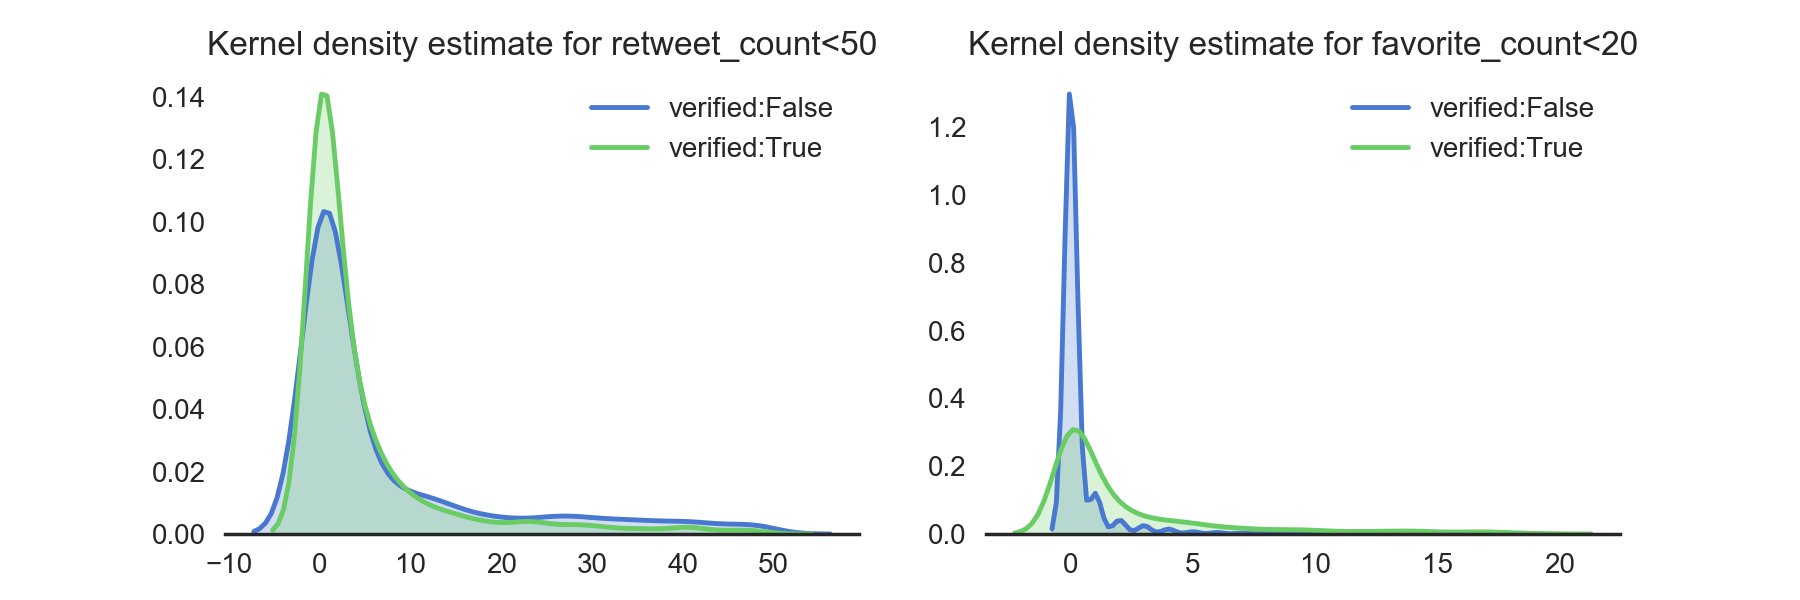

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

f, axes = plt.subplots(1, 2, figsize=(9, 3)) # sharex=True)
sns.despine(left=True)

sns.set(style="white", palette="muted", color_codes=True)
for g, group in df.groupby(["isVerified"]):
    group = group[group.retweet_count < 50]
    sns.distplot(group["retweet_count"].values, hist=False,  kde_kws={"shade": True}, label="verified:%s"%g, ax=axes[0])
t = axes[0].set_title('Kernel density estimate for retweet_count<50')

for g, group in df.groupby(["isVerified"]):
    group = group[group.favorite_count < 20]
    sns.distplot(group["favorite_count"].values, hist=False,  kde_kws={"shade": True}, label="verified:%s"%g, ax=axes[1])
t = axes[1].set_title('Kernel density estimate for favorite_count<20')

The figures suggest that there's no significant difference for the retweet_count, favorite_count distributions between verified and non-verified accounts. A statistical significance test can be ran but the figures are not promising.<br>
<br>
***

## Question 2: Verified piet gets more engagement than non-verified piet


<IPython.core.display.Javascript object>


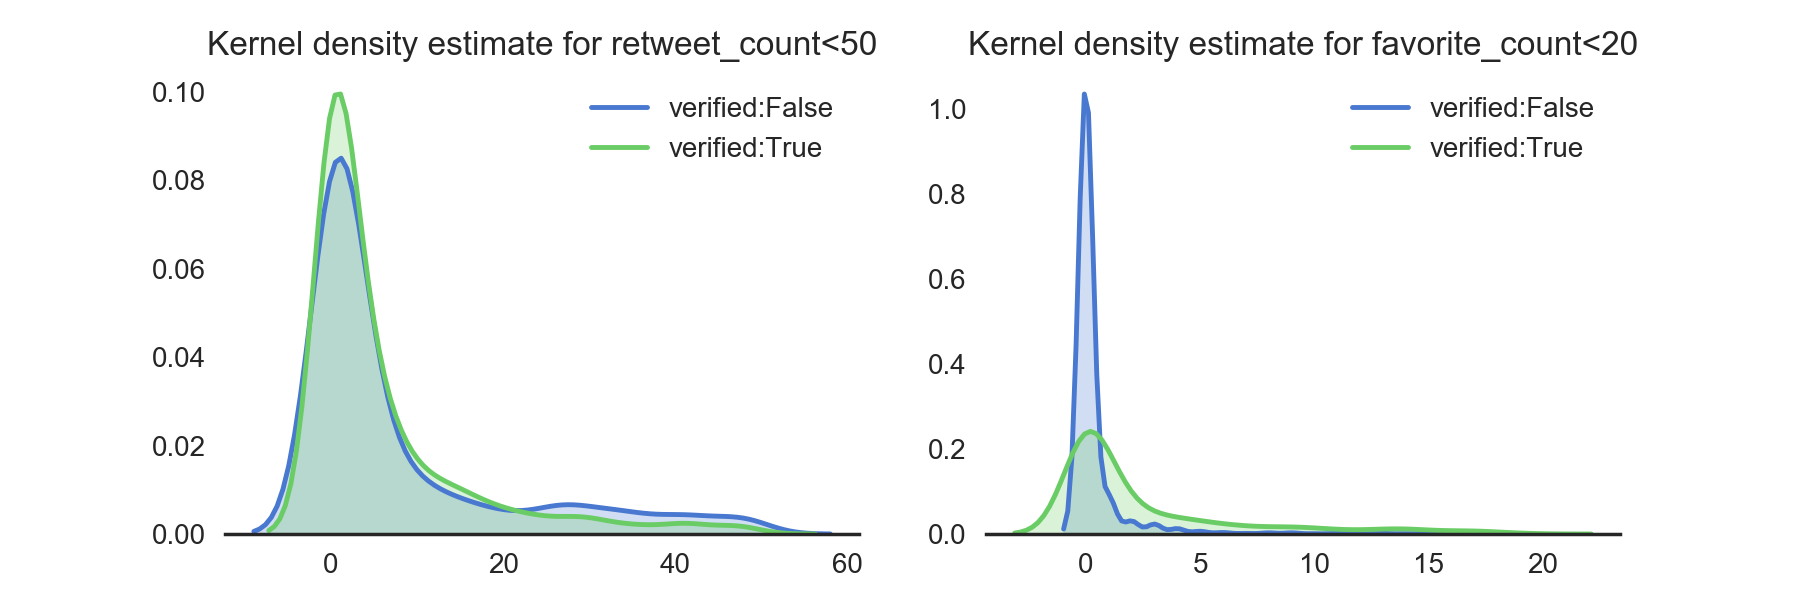

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

# Filter for piet
df_piet = df[df.zp == True]

f, axes = plt.subplots(1, 2, figsize=(9, 3)) # sharex=True)
sns.despine(left=True)

sns.set(style="white", palette="muted", color_codes=True)
for g, group in df_piet.groupby(["isVerified"]):
    group = group[group.retweet_count < 50]
    sns.distplot(group["retweet_count"].values, hist=False,  kde_kws={"shade": True}, label="verified:%s"%g, ax=axes[0])
t = axes[0].set_title('Kernel density estimate for retweet_count<50')

for g, group in df_piet.groupby(["isVerified"]):
    group = group[group.favorite_count < 20]
    sns.distplot(group["favorite_count"].values, hist=False,  kde_kws={"shade": True}, label="verified:%s"%g, ax=axes[1])
t = axes[1].set_title('Kernel density estimate for favorite_count<20')

Again, the figures don't suggest a significant difference between the distributions.<br>
<br>
***

## Question 4: non-verified piet gets more engagement than non-verified non-piet

<IPython.core.display.Javascript object>


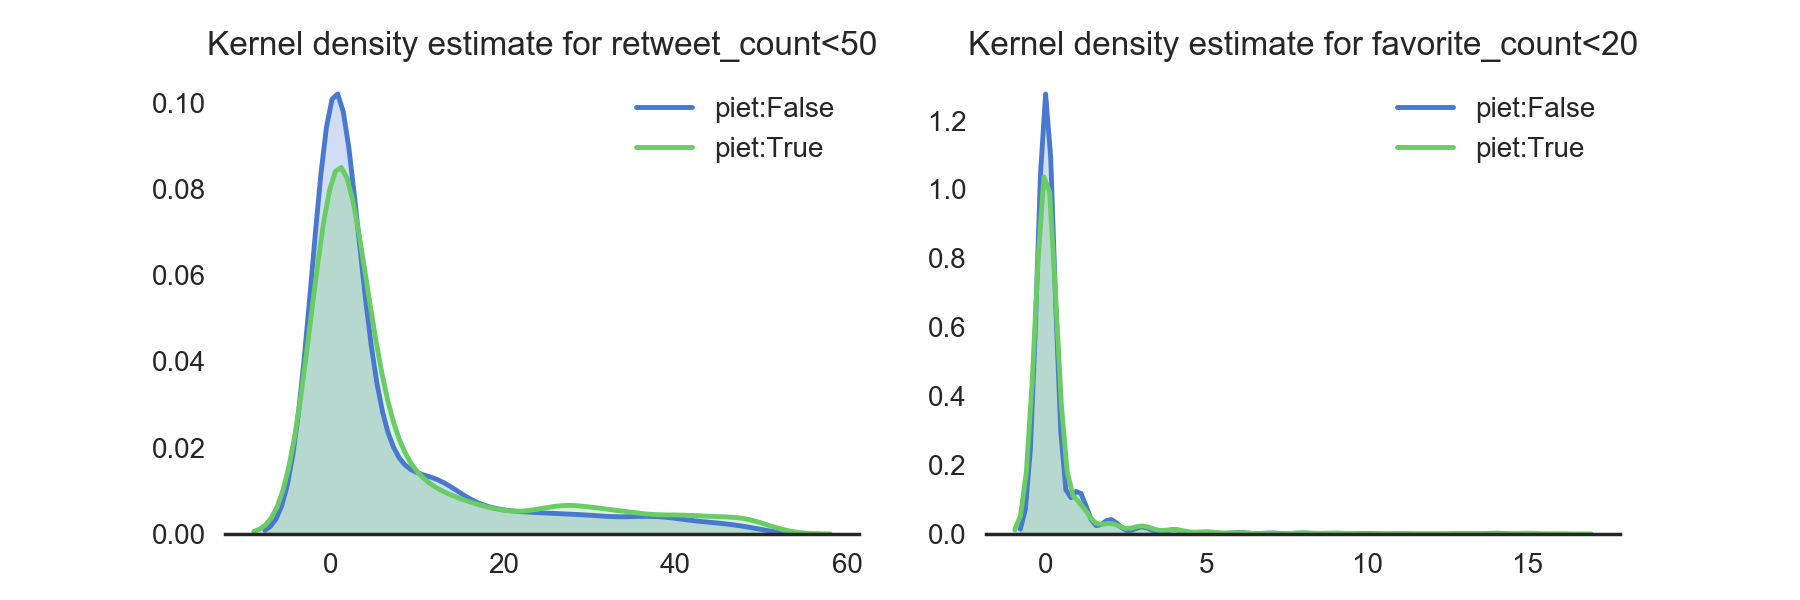

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

# Filter for non-verified
df_nonver = df[df.isVerified == False]

f, axes = plt.subplots(1, 2, figsize=(9, 3)) # sharex=True)
sns.despine(left=True)

sns.set(style="white", palette="muted", color_codes=True)
for g, group in df_nonver.groupby(["zp"]):
    group = group[group.retweet_count < 50]
    sns.distplot(group["retweet_count"].values, hist=False,  kde_kws={"shade": True}, label="piet:%s"%g, ax=axes[0])
t = axes[0].set_title('Kernel density estimate for retweet_count<50')

for g, group in df_nonver.groupby(["zp"]):
    group = group[group.favorite_count < 20]
    sns.distplot(group["favorite_count"].values, hist=False,  kde_kws={"shade": True}, label="piet:%s"%g, ax=axes[1])
t = axes[1].set_title('Kernel density estimate for favorite_count<20')

I don't see any statistical significance.